In [1]:
#import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from scipy.stats.distributions import gamma, pearson3
from scipy.stats.distributions import poisson
from scipy.stats.distributions import expon

import statistics
from scipy.stats import norm
from scipy import stats
import scipy.stats

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.neural_network import MLPClassifier


from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Dropout, Flatten
from tensorflow.keras import  regularizers

In [2]:

#import data
data = pd.read_csv("../MODELING TOKEN BUCKET USING MACHINE LEARNING MODELS/H264-data/silence_of_the_lamb_G16B3_QP10.csv",infer_datetime_format=True,
                  parse_dates=['arrival_time'], index_col='arrival_time', 
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [3]:
data.head()

,decoded_frame,video_frame,frame_size,x,y,z
arrival_time,,,,,,
0.00000,0,I,536,98.19,92.17,92.17
133.33333,4,P,152,98.19,92.17,92.17
33.33333,1,B,136,98.19,92.17,92.17
66.66667,2,B,136,98.19,92.17,92.17
100.00000,3,B,136,98.19,92.17,92.17


In [4]:
data.shape

(53997, 6)

In [5]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)

data.drop(('x'), axis=1, inplace=True)
data.drop(('y'), axis=1, inplace=True)
data.drop(('z'), axis=1, inplace=True)

In [6]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [7]:
data.head()

,video_frame,frame_size
arrival_time,,
0.00000,1,536
133.33333,2,152
33.33333,0,136
66.66667,0,136
100.00000,0,136


In [8]:
data.frame_size.dropna(0,inplace= True)

In [9]:
data.reset_index(inplace=True)

In [10]:

data.head()

,arrival_time,video_frame,frame_size
0,0.00000,1,536
1,133.33333,2,152
2,33.33333,0,136
3,66.66667,0,136
4,100.00000,0,136


In [11]:
data.sort_values('arrival_time', inplace=True)
data.reset_index(drop=True, inplace=True)

In [12]:
data.head()

,arrival_time,video_frame,frame_size
0,0.00000,1,536
1,33.33333,0,136
2,66.66667,0,136
3,100.00000,0,136
4,133.33333,2,152


In [13]:
data.isnull().sum()

arrival_time    0
video_frame     0
frame_size      0
dtype: int64

# LSTM model

In [14]:
data.frame_size.dropna(0, inplace=True)

In [15]:
dataset = data.frame_size.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset.shape

(53997,)

In [16]:
dataset = pd.DataFrame(dataset)
print(dataset.shape)

(53997, 1)


In [17]:
# *****************split into train and test sets********************

test_split = int(len(dataset) * 0.8)

train = dataset[:test_split]
test = dataset[test_split:]

In [18]:
#********Data normalization**************************

scaler = MinMaxScaler(feature_range=(-1, 1))

train = scaler.fit_transform(train)
test = scaler.transform(test)

In [19]:
# ******************frame a lagged sequence problem*************

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43193, 3) (43193,)
(10796, 3) (10796,)


In [20]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train',X_train.shape)
print('X_test', X_test.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

X_train (43193, 3, 1)
X_test (10796, 3, 1)


In [21]:
#********************Build Model****************************

def lstm_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(128, input_shape=(look_back,1),kernel_regularizer=regularizers.l2(0.001)
                ))
    model.add(tf.keras.layers.Dropout(rate=0.50))
    
    #model.add(LSTM(128, kernel_initializer='glorot_uniform',activation='relu'))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mse')
      
    return model

In [22]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]

model_lstm =lstm_model()


history_lstm = model_lstm.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs = 100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1080/1080 [==============================] - 6s 4ms/step - loss: 0.1102 - val_loss: 0.0431
Epoch 2/100
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0670 - val_loss: 0.0447
Epoch 3/100
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0662 - val_loss: 0.0464
Epoch 4/100
1080/1080 [==============================] - 3s 3ms/step - lo

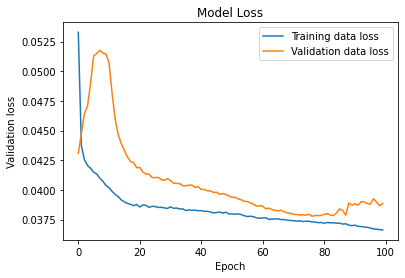

In [23]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [24]:
# convert 1 D to 2D array
y_train = y_train.reshape((y_train.shape[0], 1))
#print(test_y.shape)

# convert 1 D to 2D array
y_test = y_test.reshape((y_test.shape[0], 1))
#print(test_y.shape)

In [25]:
# Data frame for evaluation metrics

models = pd.DataFrame(index=['RPE'], 
                      columns=['KNN', 'Bagging', 'RandomForest','Linear Regression', "LSTM"])


In [26]:
# Relative Percentage Error
def mean_relative_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [27]:

yhat_lstm = model_lstm.predict(X_test)
rpe_lstm = mean_relative_percentage_error(yhat_lstm, y_test)
mse_lstm = mean_squared_error(y_test, yhat_lstm)
#rmse_lstm = sqrt(mse_lstm)

#rpe_rnn = mean_relative_percentage_error(y_test, yhat)
models.loc['RPE','LSTM'] = mean_relative_percentage_error(yhat_lstm, y_test)
#models.loc['rmse','LSTM'] = np.sqrt(mse_lstm)

# Machine learning models

In [28]:
dataset= pd.DataFrame(data.frame_size)

In [29]:
dataset.shape

(53997, 1)

In [30]:
test_split = int(len(dataset) * 0.80)
X_train = dataset[:test_split]
y_train = dataset [:test_split]
X_test = dataset [test_split:]
y_test = dataset [test_split:]

In [31]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(43197, 1) (43197, 1) (10800, 1) (10800, 1)


In [32]:
# ********Normalize the data******************

robust_scaler = RobustScaler()
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

In [33]:
y_train.shape

(43197, 1)

In [34]:
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0])

# KNN Model

In [35]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor

# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean', n_jobs=-1)

# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)
knn_pred= knn.predict(X_test)

# 4. Evaluate the model
#models.loc['train_mse','KNN'] = mean_squared_error(y_pred=knn.predict(X_train), 
                                                   # y_true=y_train)

#models.loc['RMSE','KNN'] = np.sqrt(mean_squared_error(y_pred=knn.predict(X_test), 
                                                 #  y_true=y_test))
models.loc['RPE','KNN'] = mean_relative_percentage_error(y_pred=knn.predict(X_test), 
                                                   y_true=y_test)

# Bagging Model

In [36]:
y_train.shape

(43197,)

In [37]:
# 1. Import the estimator object (model)
from sklearn.ensemble import BaggingRegressor
# 2. Create an instance of the estimator
knn_for_bagging = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean')

bagging = BaggingRegressor(base_estimator=knn_for_bagging, n_estimators=15, max_features=0.75, 
                            random_state=55, n_jobs=-1)
# 3. Use the trainning data to train the estimator

bagging.fit(X_train, y_train)

bagging_pred = bagging.predict(X_test)
# 4. Evaluate the model
#models.loc['train_mse','Bagging'] = mean_squared_error(y_pred=bagging.predict(X_train), 
                                                   # y_true=y_train)

#models.loc['RMSE','Bagging'] = np.sqrt(mean_squared_error(y_pred=bagging.predict(X_test), 
                                                 #  y_true=y_test))
models.loc['RPE','Bagging'] = mean_relative_percentage_error(y_pred=bagging.predict(X_test), 
                                                   y_true=y_test)

# Random Forest

In [38]:
# 1. Import the estimator object (model)
from sklearn.ensemble import RandomForestRegressor

# 2. Create an instance of the estimator
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)

# 3. Use the trainning data to train the estimator
RF.fit(X_train, y_train)

RF_pred = RF.predict(X_test)
# 4. Evaluate the model
#models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), 
                                                  #  y_true=y_train)

#models.loc['RMSE','RandomForest'] = np.sqrt(mean_squared_error(y_pred=RF.predict(X_test), y_true=y_test))
models.loc['RPE','RandomForest'] = mean_relative_percentage_error(y_pred=RF.predict(X_test), y_true=y_test)

# Boosting Model

# Linear Regression model

In [39]:

# 1. Import the estimator object (model)
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)

# 4. Prediction
lr_pred = linear_regression.predict(X_test)

# 5. Evaluate the model
#y_pred=linear_regression.predict(X_test)

#models.loc['RMSE','Regression'] = np.sqrt(mean_squared_error(y_pred=linear_regression.predict(X_test), y_true=y_test))

#models.loc['RMSE','LR'] = np.sqrt(mean_squared_error(y_pred=linear_regression.predict(X_test), 
                                              #  y_true=y_test))

models.loc['RPE','Linear Regression'] = mean_relative_percentage_error(y_pred=linear_regression.predict(X_test), 
                                                y_true=y_test)

In [40]:
models

,KNN,Bagging,RandomForest,Linear Regression,LSTM
RPE,1537.363387,1537.263584,1537.313969,1537.34828,19.501488


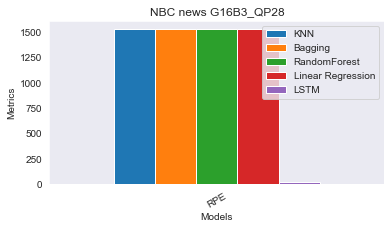

In [41]:
import seaborn as sns
sns.set_style("dark")


models.plot(kind='bar', width=0.8, figsize=(6,3))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title('NBC news G16B3_QP28');
plt.xlabel('Models')
plt.ylabel('Metrics')
#ax2.set_ylabel('mape')

plt.show()

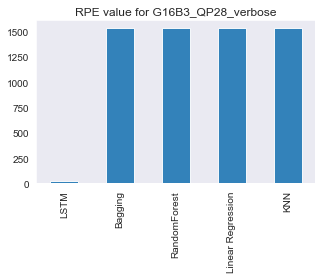

In [42]:
fig, ax = plt.subplots(figsize=(5,3))
bar_width = 0.15

#models.loc['rmse'].sort_values().plot(kind='bar', ax=ax, alpha=0.9)
models.loc['RPE'].sort_values().plot(kind='bar', ax=ax, alpha=0.9)
ax.set_title('RPE value for G16B3_QP28_verbose');

Text(0, 0.5, 'Models')

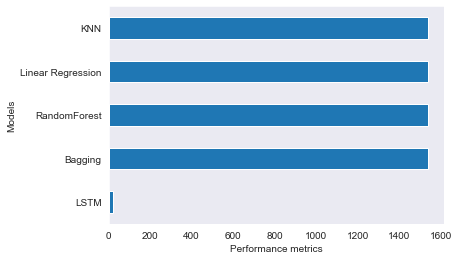

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
models.loc['RPE'].sort_values().plot(kind='barh', ax=ax)
#ax.set_title('RPE value for G16B3_QP28_verbose');
plt.xlabel('Performance metrics')
plt.ylabel('Models')

# Best performing model

In [45]:

# 4. Evaluate the model
#y_pred_RF = RF.predict(X_test)

#boosting_pred= boosting.predict(X_test)

knn_pred= knn.predict(X_test)

# 4. Prediction
#lr_pred = linear_regression.predict(X_test)

In [46]:
X_test=robust_scaler.inverse_transform(X_test)

In [47]:
#print(y_pred_RF.shape)

In [48]:
class_0=[]

for x,p in zip(X_test, knn_pred):
    class_0.append(x[0])


In [49]:
print(len(class_0))


10800


In [50]:
df0=pd.DataFrame(class_0, columns =['class0_frameSize'])
print(df0.head())

   class0_frameSize
0           24312.0
1           28872.0
2           28920.0
3          194096.0
4             184.0


In [51]:
df0_mean = np.mean(df0.class0_frameSize)
print(df0_mean)

37089.48074074074


In [52]:

df0_mean = np.ceil(df0_mean)
print(df0_mean)

37090.0


In [53]:
num_of_frames = data.shape[0]
total = np.sum(data.frame_size)
print(num_of_frames)
print(total)

53997
3209958344


In [54]:
peak_frame = max(data.frame_size)
print ('peak_frame', peak_frame)

peak_frame 657824


In [55]:
peak_frame = max(data.frame_size)
mean_val = np.mean(data.frame_size)
var_val = np.var(data.frame_size)
#num_of_frames = data.shape[0]
total = np.sum(data.frame_size)

In [56]:
#Token Bucket algorithm using mean token generation rate

for m in range(10):  # 
    byte_sent = 0   # incoming packet forwarded 
    deleted_bytes = 0
    bucket_size = 0  #  token bucket_size
    marked_bytes = 0  # non conforming packets marked
    j = 0
    l = 0
    max_bucket_size = m * peak_frame  # maximum bucket size - we increased the bucket size to 2,3,4.. 
                                       # ...and 10 times peak value, keeping the token generation rate equal 
    
    for i in range(data.shape[0]):
        bucket_size += df0_mean  # number of token added to the bucket - Initially we assigned the token generation rate
                                    #in the token bucket equal to the mean rate of each trace
            
            
        if bucket_size > max_bucket_size: #  if the bucket size is greater than the maximum bucket size
            bucket_size = max_bucket_size # assigned bucket size equal to the peak of the trace
            #l += 1
        
        if data.loc[i, 'frame_size'] <= bucket_size:  # if incoming packets less than the number of token 
                                                        #available in the bucket
            byte_sent += data.loc[i, 'frame_size']  # incoming packets is forwarded
            bucket_size = (bucket_size - data.loc[i, 'frame_size'])  # reset bucket size = number of tokens
                                                                      #in the bucket- packet forwarded
            
        else:
            byte_sent += bucket_size  # if incoming packets is greater than the number of token available in the bucket
            marked_bytes += (data.loc[i, 'frame_size'] - bucket_size)  # incoming packet is marked as non-conforming
            bucket_size = 0  # resetting bucket size to 0
            
    percent = marked_bytes * 100 / total
    print(percent)
            


100.0
42.566395434818766
41.994164457605805
41.60507828695985
41.258298023570866
40.987395131131336
40.7871839348704
40.60274490590087
40.4458309693255
40.349143857924155


In [57]:
mean_frame = np.mean(data.frame_size)

In [58]:
#Token Bucket algorithm using mean token generation rate

for m in range(10):  # 
    byte_sent = 0   # incoming packet forwarded 
    deleted_bytes = 0
    bucket_size = 0  #  token bucket_size
    marked_bytes = 0  # non conforming packets marked
    j = 0
    l = 0
    max_bucket_size = m * peak_frame  # maximum bucket size - we increased the bucket size to 2,3,4.. 
                                       # ...and 10 times peak value, keeping the token generation rate equal 
    
    for i in range(data.shape[0]):
        bucket_size += mean_frame  # number of token added to the bucket - Initially we assigned the token generation rate
                                    #in the token bucket equal to the mean rate of each trace
            
            
        if bucket_size > max_bucket_size: #  if the bucket size is greater than the maximum bucket size
            bucket_size = max_bucket_size # assigned bucket size equal to the peak of the trace
            #l += 1
        
        if data.loc[i, 'frame_size'] <= bucket_size:  # if incoming packets less than the number of token 
                                                        #available in the bucket
            byte_sent += data.loc[i, 'frame_size']  # incoming packets is forwarded
            bucket_size = (bucket_size - data.loc[i, 'frame_size'])  # reset bucket size = number of tokens
                                                                      #in the bucket- packet forwarded
            
        else:
            byte_sent += bucket_size  # if incoming packets is greater than the number of token available in the bucket
            marked_bytes += (data.loc[i, 'frame_size'] - bucket_size)  # incoming packet is marked as non-conforming
            bucket_size = 0  # resetting bucket size to 0
            
    percent = marked_bytes * 100 / total
    print(percent)
            


100.0
24.811321621714526
24.13566456591133
23.66802896775377
23.31716117814644
23.039520022093107
22.773644225953436
22.549380471776857
22.347136625819235
22.183950499238104
